# MaKE MaKI Indices for 2014 Anomalies, 2 year climatology:

Climatology calculated for 2014-2015. Anomalies calculated for each month. This is looking at January 2014 as an example.

Forecast data from UFS prototype 8. Observations from Scatterometer data. Forecast data is regridded from tripolar to lat/lon with XESMF, and then interpolated to the observation grid.

Filter designed for 15-35 day variability using scatterometer observation, computed with CNN.

EOFs calculated for observations.

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from compute_mjo_enso import*

In [54]:
fil1='/scratch/ldoyle4/new_anoms/slice_interp_split/taux_20140101.nc'

ds=xr.open_dataset(fil1)
uflxa=ds.taux_anom
ds.close()

In [55]:
datadir1='/home/ldoyle4/cnn_olr_project/windstress/1535days/'
datadir2='/scratch/ldoyle4/windstress/final/'

filt1=np.loadtxt(datadir1+'taux.filter1.txt', delimiter=',')
filt2=np.loadtxt(datadir1+'taux.filter2.txt', delimiter=',')

uflx_eof = xr.open_dataset(datadir2+'obs_taux_eof.nc').taux_eof
uflx_eof = uflx_eof.rename(num='time')

In [56]:
def calc_tau_MJO(flxa,flx_eof,filt1,filt2):

    # # reshape the data
    flxa_rg = flxa.stack(grid=("lat","lon")).transpose("time","grid").astype('float32')
    flx_eof_rg = flx_eof.stack(grid=("lat","lon")).transpose("time","grid").astype('float32')

    # find indices where the data is not missing and subset the uflxi
    # model and observation have different position of missing data (where model has data, observation does not)
        # so need to edit the indx line to include both model and observation
    #indx = np.squeeze(np.argwhere(~np.isnan(flxa_rg[10,:].data)))
    indx = np.squeeze((np.argwhere(~np.isnan(flxa_rg[0,:].data) & ~np.isnan(flx_eof_rg[0,:].data))))
    flx = flxa_rg[:,indx]


    print('Calculating 30-90-day band pass filtered daily UFLX anomalies')

    flxi = copy.deepcopy(flx)
    for i in range(filt1.shape[1]):

        LowPass = np.convolve(flx[:,i],filt1[:,i],mode='same')
        HighPass = flx[:,i] - LowPass
        flxi[:,i] = np.convolve(HighPass,filt2[:,i],mode='same')

    flx_bpf = copy.deepcopy(flxa_rg)	
    flx_bpf[:,indx] = flxi
    flx_bpf = flx_bpf.unstack()
    flx_bpf = flx_bpf.rename('flx_bpf')

    un = flx_eof_rg[:,indx]

    ## Projecting EOFs onto PCs of FLX 30-90 day anomalies

    pct = (un.data@flxi.T.data)/flxi.T.shape[0]
    pc = np.transpose(pct)
    xx = np.std(pc,axis=0,ddof=1)

    flxMJO = np.zeros(flx.T.shape)

    for j in range(4):
      
        r = flxi.T.data@pc[:,j]
        r = r/xx[j]
    
        tt = np.expand_dims(r,1) * np.expand_dims(pct[j,:],0)
    
        flxMJO = flxMJO + tt
    
    flx_MJO = copy.deepcopy(flxa_rg.T)
    flx_MJO[indx,:] = flxMJO

    # Reshape to (time,lat,lon)
    flx_MJO = flx_MJO.unstack()

    flx_MJO = flx_MJO.rename('flx_mjo')

    return flx_MJO


In [7]:
uflx_mjo=calc_tau_MJO(uflxa,uflx_eof,filt1,filt2)

Calculating 30-90-day band pass filtered daily UFLX anomalies


In [8]:
uflx_mjo

<xarray.DataArray 'flx_mjo' (time: 35, lat: 117, lon: 313)>
array([[[           nan,            nan,            nan, ...,
          4.4368099e-02,  4.3158825e-02,  4.1783944e-02],
        [           nan,            nan,            nan, ...,
         -6.5839799e-07,  4.4305439e-06, -1.3811083e-07],
        [           nan,            nan,            nan, ...,
         -2.1429358e-05, -2.3284236e-05, -2.3964782e-05],
        ...,
        [ 3.7850466e-05,  3.8214454e-05,  3.7245220e-05, ...,
                    nan,            nan,            nan],
        [ 3.2607033e-05,  3.3239132e-05,  3.2387776e-05, ...,
                    nan,            nan, -7.2000717e-06],
        [-2.8521465e-02, -3.2027584e-02, -3.7199020e-02, ...,
                    nan,            nan, -7.1319938e-04]],

       [[           nan,            nan,            nan, ...,
          9.5131099e-03,  6.7477226e-03,  4.1295141e-03],
        [           nan,            nan,            nan, ...,
          4.7997327e-07,  3.3925357e-06, -1.1187210e-06],
        [           nan,            nan,            nan, ...,
         -2.0032292e-05, -2.0743955e-05, -2.0836293e-05],
...
        [ 7.5340511e-05,  7.6009848e-05,  7.4073985e-05, ...,
                    nan,            nan,            nan],
        [ 6.5163229e-05,  6.6340297e-05,  6.4712724e-05, ...,
                    nan,            nan, -1.3667322e-05],
        [-6.6800178e-03, -5.9137093e-03, -5.7996530e-03, ...,
                    nan,            nan,  4.2757995e-02]],

       [[           nan,            nan,            nan, ...,
         -6.0352497e-02, -5.9766971e-02, -5.8813304e-02],
        [           nan,            nan,            nan, ...,
         -8.4026334e-07,  1.0136582e-05, -1.1508697e-06],
        [           nan,            nan,            nan, ...,
         -5.2499843e-05, -5.6236520e-05, -5.7508769e-05],
        ...,
        [ 8.7559856e-05,  8.8418361e-05,  8.5563464e-05, ...,
                    nan,            nan,            nan],
        [ 7.5956668e-05,  7.7193814e-05,  7.4524389e-05, ...,
                    nan,            nan, -2.1974027e-05],
        [-2.3675680e-02, -2.0490259e-02, -2.0261440e-02, ...,
                    nan,            nan,  1.0755323e-02]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -29.0 -28.5 -28.0 -27.5 -27.0 ... 27.5 28.0 28.5 29.0
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00

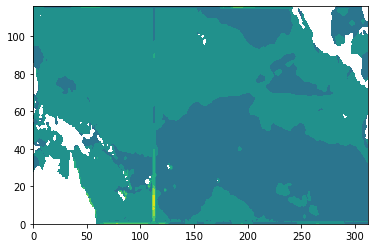

In [9]:
plt.contourf(uflx_mjo[3,:,:])

In [10]:
uflx_mjo.shape

(35, 117, 313)

In [11]:
fil2='/scratch/ldoyle4/new_anoms/slice_interp_split/tauy_20140101.nc'
ds=xr.open_dataset(fil2)
vflxa=ds.tauy_anom
ds.close()

In [12]:
filt1=np.loadtxt(datadir1+'tauy.filter1.txt', delimiter=',')
filt2=np.loadtxt(datadir1+'tauy.filter2.txt', delimiter=',')

#ds1 = xr.open_dataset(datadir2+'obs_taux_eof.nc')
#ds1.rename_dims(num='time')
vflx_eof = xr.open_dataset(datadir2+'obs_tauy_eof.nc').tauy_eof
vflx_eof = vflx_eof.rename(num='time')

In [13]:
vflx_mjo=calc_tau_MJO(vflxa,vflx_eof,filt1,filt2)

Calculating 30-90-day band pass filtered daily UFLX anomalies


In [14]:
vflx_mjo

<xarray.DataArray 'flx_mjo' (time: 35, lat: 117, lon: 313)>
array([[[            nan,             nan,             nan, ...,
         -3.49772982e-02, -3.57371196e-02, -3.65562551e-02],
        [            nan,             nan,             nan, ...,
          6.02678540e-07,  9.65384788e-06, -3.92848960e-06],
        [            nan,             nan,             nan, ...,
         -3.75537747e-05, -3.92888505e-05, -4.15785544e-05],
        ...,
        [ 7.64561773e-05,  7.96861859e-05,  8.46025869e-05, ...,
                     nan,             nan,  1.15854127e-05],
        [ 7.63701901e-05,  8.01212082e-05,  8.47611882e-05, ...,
                     nan,             nan,  1.29329628e-05],
        [ 1.37376875e-01,  1.41411617e-01,  1.49051070e-01, ...,
                     nan,             nan, -9.05021466e-03]],

       [[            nan,             nan,             nan, ...,
         -7.72562623e-03, -6.37646019e-03, -5.09621948e-03],
        [            nan,             nan,             nan, ...,
         -1.65735699e-07,  8.11487780e-07, -1.07288110e-06],
        [            nan,             nan,             nan, ...,
         -8.14508803e-06, -7.88759189e-06, -7.65739696e-06],
...
                     nan,             nan, -1.43862373e-04],
        [ 5.19111272e-05,  3.77761935e-05,  2.46325726e-05, ...,
                     nan,             nan, -1.61525983e-04],
        [ 1.32696301e-01,  1.18819013e-01,  1.13883212e-01, ...,
                     nan,             nan, -1.15074001e-01]],

       [[            nan,             nan,             nan, ...,
          5.69801182e-02,  5.95455021e-02,  6.34072572e-02],
        [            nan,             nan,             nan, ...,
          1.03609580e-06, -5.19575860e-06,  5.29984800e-06],
        [            nan,             nan,             nan, ...,
          2.95069513e-05,  3.10613759e-05,  3.27522794e-05],
        ...,
        [ 6.51704395e-05,  5.84951958e-05,  5.11079015e-05, ...,
                     nan,             nan, -1.31227716e-04],
        [ 6.10964562e-05,  5.45140974e-05,  4.85862911e-05, ...,
                     nan,             nan, -1.46579259e-04],
        [ 1.55039579e-01,  1.36683524e-01,  1.28420249e-01, ...,
                     nan,             nan, -7.39738941e-02]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -29.0 -28.5 -28.0 -27.5 -27.0 ... 27.5 28.0 28.5 29.0
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00

In [15]:
vflx_mjo.shape

(35, 117, 313)

In [16]:
fil3='/scratch/ldoyle4/new_anoms/slice_interp_split/ssu_20140101.nc'
ds=xr.open_dataset(fil3)
u=ds.SSU_anom
#u = u.drop_duplicates('time', keep='first')
ds.close()

In [17]:
fil4='/scratch/ldoyle4/new_anoms/slice_interp_split/ssv_20140101.nc'
ds=xr.open_dataset(fil4)
v=ds.SSV_anom
#v = v.drop_duplicates('time', keep='first')
ds.close()

In [18]:
def calc_wpower_MJO(u,v,uflx_mjo,vflx_mjo):

     lat_ws = u.lat
     lon_ws = u.lon

     print('calculating the meridional structure of Kelvin wave')
     import math

     beta=2.28E-11
     hequiv=90
     ynd=lat_ws[len(lat_ws)-1]
     ysd=lat_ws[0]

     cwave=np.sqrt(9.81E-2*hequiv)

     eleq = np.sqrt(cwave/beta)/111000
     yn = ynd/eleq
     ys = ysd/eleq

     dy = (yn-ys)/len(lat_ws)
     dyinv = 2/dy
     enorm = np.sqrt(np.pi)
     anorm = (enorm*(math.erf(yn)+math.erf(-ys)))**(-0.5)

     yy = np.zeros(len(lat_ws))

     for j in range(len(lat_ws)):
         yy[j] = ys+((j+1)-0.5)*dy

     jnot = np.argmin(abs(yy))

     jnot1 = jnot+1

     phik = np.zeros(len(lat_ws))
     phik[jnot] = anorm*np.exp(-0.5*yy[jnot]*yy[jnot])

     for j in range(jnot1,len(lat_ws)):
         phik[j] = phik[j-1]*(dyinv-yy[j-1])/(dyinv+yy[j])

     for j in range(jnot+1):
         k=jnot-j
         phik[k]=phik[k+1]*(dyinv+yy[k+1])/(dyinv-yy[k])


     phik2d = np.ones((len(lat_ws),len(lon_ws)))
     phik2d = phik2d * np.expand_dims(phik,1)

     print('Projecting the ocean current anomalies onto the meridional structure of Kelvin wave')
     u_day_prim_kelvin = u*phik2d
     v_day_prim_kelvin = v*phik2d

     # print('calculating the MJO wind power')
     wmjoks = u_day_prim_kelvin*uflx_mjo.data + v_day_prim_kelvin*vflx_mjo.data
     wmjoks = wmjoks.rename('wmjoks')

     return wmjoks


In [19]:
wpower=calc_wpower_MJO(u,v,uflx_mjo,vflx_mjo)

calculating the meridional structure of Kelvin wave
Projecting the ocean current anomalies onto the meridional structure of Kelvin wave


In [20]:
wpower

<xarray.DataArray 'wmjoks' (time: 35, lat: 117, lon: 313)>
array([[[            nan,             nan,             nan, ...,
          1.88674975e-22,  3.40926399e-22,  5.56369438e-22],
        [            nan,             nan,             nan, ...,
         -4.91312521e-26,  1.67285464e-25,  8.14517625e-26],
        [            nan,             nan,             nan, ...,
         -4.39779002e-24, -5.84267750e-24, -5.65268789e-24],
        ...,
        [ 3.02711227e-23,  3.01369709e-23,  2.62827428e-23, ...,
                     nan,             nan,             nan],
        [ 6.69829039e-24,  6.46945741e-24,  8.20412185e-24, ...,
                     nan,             nan, -3.10526789e-26],
        [ 1.87698975e-21,  1.75602781e-21,  2.08970195e-21, ...,
                     nan,             nan, -8.62527430e-23]],

       [[            nan,             nan,             nan, ...,
         -8.25778028e-23, -3.95059768e-23,  9.01959665e-24],
        [            nan,             nan,             nan, ...,
         -3.30470451e-27, -4.04310026e-26,  4.27659714e-26],
        [            nan,             nan,             nan, ...,
         -6.25314377e-25, -8.94992939e-25, -1.34454776e-25],
...
        [ 2.47191260e-23,  2.42078876e-23,  2.82093737e-23, ...,
                     nan,             nan,             nan],
        [ 6.19213176e-24,  3.60651152e-24,  3.58843818e-24, ...,
                     nan,             nan,  2.55991320e-23],
        [ 2.34966363e-21,  1.11117328e-21,  1.07852006e-21, ...,
                     nan,             nan,  3.45940349e-21]],

       [[            nan,             nan,             nan, ...,
          2.21954073e-22,  8.03366846e-23,  3.90826383e-22],
        [            nan,             nan,             nan, ...,
         -1.20205233e-26, -1.06443680e-25, -1.18512983e-25],
        [            nan,             nan,             nan, ...,
         -2.44240256e-24,  8.00581058e-25,  6.16339528e-24],
        ...,
        [ 3.15190698e-23,  3.35530490e-23,  4.48869056e-23, ...,
                     nan,             nan,             nan],
        [ 7.62642640e-24,  5.83775413e-24,  7.46093416e-24, ...,
                     nan,             nan,  2.21115217e-23],
        [ 2.30372624e-21,  9.29488207e-22,  1.14898153e-21, ...,
                     nan,             nan,  1.80275237e-21]]])
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00
  * lat      (lat) float32 -29.0 -28.5 -28.0 -27.5 -27.0 ... 27.5 28.0 28.5 29.0
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [21]:
fil5='/scratch/ldoyle4/new_anoms/slice_interp_split/sst_20140101.nc'
ds = xr.open_dataset(fil5)
sst = ds.SST_anom.sel(lat=slice(-5,5)).mean(dim='lat',skipna=True)
#sst = sst.drop_duplicates('time', keep='first')
ds.close()
meofs=xr.open_dataset('/scratch/ldoyle4/windstress/final/obs_multivarEOFs.nc').multieof

In [22]:
wmjoks = wpower.sel(lat=slice(-5,5)).mean(dim='lat',skipna=True)

In [23]:
wmjoks

<xarray.DataArray 'wmjoks' (time: 35, lon: 313)>
array([[ 2.26177363e-07,  4.05210372e-07,  1.44846610e-06, ...,
         7.90168163e-08,  1.27930640e-05,  7.11733271e-07],
       [ 1.03077338e-08,  4.92750232e-08, -4.77194272e-06, ...,
         2.20203034e-06,  2.46201476e-05, -2.24249957e-06],
       [-4.01949714e-08, -5.45760121e-08,  3.44049310e-06, ...,
         4.07709549e-06,  6.53907519e-05,  2.18535031e-05],
       ...,
       [ 5.05372088e-07,  4.58922856e-07, -8.97118663e-06, ...,
         2.64988714e-06,  2.38654623e-05, -6.40943721e-06],
       [ 4.25191952e-07,  1.80654781e-07,  2.01510587e-05, ...,
        -5.70548645e-07,  6.46992771e-06, -6.56289502e-06],
       [-1.38469862e-07, -3.46120559e-07,  7.37959733e-06, ...,
        -4.92914522e-07,  1.69551926e-04, -9.01685092e-06]])
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [24]:
meofs

<xarray.DataArray 'multieof' (num: 2, var: 2, lon: 313)>
array([[[-0.001396, -0.003175, ..., -0.003314, -0.003112],
        [ 0.030277,  0.032927, ..., -0.046098, -0.044281]],

       [[-0.004745, -0.00656 , ..., -0.000107, -0.001301],
        [ 0.000428,  0.000955, ..., -0.000365, -0.000596]]])
Coordinates:
  * var      (var) int64 1 2
  * lon      (lon) float64 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0
  * num      (num) int64 1 2
Attributes:
    description:  Multivariate EOFs: MJO Wind stress and Sea Surface Temperat...

In [25]:
sst

<xarray.DataArray 'SST_anom' (time: 35, lon: 313)>
array([[-0.00873799, -0.07170116, -0.06576462, ..., -0.23877981,
        -0.37655905, -0.37763613],
       [-0.07158513, -0.11985779, -0.07760715, ..., -0.23749341,
        -0.39338347, -0.4302973 ],
       [ 0.00127019, -0.03532847,  0.04527225, ..., -0.15178797,
        -0.3362635 , -0.39741975],
       ...,
       [-0.02431583, -0.0208177 , -0.10387478, ...,  0.21419515,
         0.33352485,  0.6554033 ],
       [-0.1107395 , -0.08522999, -0.09451809, ...,  0.3261953 ,
         0.4066727 ,  0.65711725],
       [-0.01102045,  0.04386969, -0.04344053, ...,  0.69129765,
         0.67767245,  0.8474535 ]], dtype=float32)
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [28]:
nday = sst.time.shape[0]
lon = sst.lon
nlon = len(lon)
num = meofs.num
nnum = len(num)
#nvar = meofs.var.shape[1]

In [33]:
print('Normalizing the SST and MJO wind power data')
sst_std = sst.std(dim='time',skipna=True)
sst_norm = sst/sst_std
wmjoks_std = wmjoks.std(dim='time',skipna=True)
wmjoks_norm = wmjoks/wmjoks_std

Normalizing the SST and MJO wind power data


In [34]:
sst_norm

<xarray.DataArray 'SST_anom' (time: 35, lon: 313)>
array([[-0.08283251, -0.6986884 , -0.6460042 , ..., -0.9682509 ,
        -1.1974733 , -0.95817643],
       [-0.67859733, -1.1679482 , -0.7623331 , ..., -0.9630345 ,
        -1.2509756 , -1.0917937 ],
       [ 0.01204086, -0.34425655,  0.4447082 , ..., -0.6154994 ,
        -1.0693318 , -1.0083734 ],
       ...,
       [-0.23050404, -0.20285705, -1.0203594 , ...,  0.8685602 ,
         1.0606227 ,  1.6629553 ],
       [-1.0497645 , -0.8305193 , -0.9284488 , ...,  1.3227202 ,
         1.2932358 ,  1.667304  ],
       [-0.10446928,  0.42748603, -0.42671525, ...,  2.8032084 ,
         2.1550262 ,  2.1502442 ]], dtype=float32)
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00
  * lon      (lon) float32 124.0 124.5 125.0 125.5 ... 278.5 279.0 279.5 280.0

In [35]:
meofs.data

array([[[-1.39638069e-03, -3.17487967e-03, -3.69356704e-03, ...,
         -2.51462046e-03, -3.31416223e-03, -3.11241988e-03],
        [ 3.02765443e-02,  3.29272330e-02,  3.47064313e-02, ...,
         -5.15843204e-02, -4.60984271e-02, -4.42809944e-02]],

       [[-4.74508104e-03, -6.55993101e-03, -3.00698010e-03, ...,
         -2.44385265e-04, -1.06987009e-04, -1.30082403e-03],
        [ 4.27590726e-04,  9.54635076e-04,  1.41817711e-03, ...,
          3.01372775e-05, -3.64786207e-04, -5.95963370e-04]]])

In [36]:
dat_meofs = np.zeros((nnum,nlon*2))
dat_meofs[:,0:nlon] = meofs[:,0,:]
dat_meofs[:,nlon:nlon*2] = meofs[:,1,:]

In [37]:
len(dat_meofs.T)

626

In [38]:
dat = np.zeros((nday,nlon*2))
dat[:,0:nlon] = wmjoks_norm
dat[:,nlon:nlon*2] = sst_norm

In [39]:
len(dat.T)

626

In [40]:
pcs = dat_meofs.data@dat.T

pc1 = -pcs[0,:]
pc2 = -pcs[1,:]

PC1 = pc1/np.std(pc1)  # cfsv2 hindcast?
PC2 = pc2/np.std(pc2)

In [41]:
pc1

array([-49.43828775, -53.12427989, -55.46750759, -56.96120287,
       -56.42917484, -55.30943109, -53.19970661, -51.49620252,
       -51.18712942, -49.25685054, -45.76600708, -43.69878822,
       -42.90660786, -42.701768  , -42.77079811, -45.73110654,
       -47.56882871, -48.51371483, -49.02407161, -47.73262874,
       -47.3566681 , -46.58581809, -47.81636914, -47.49033268,
       -51.13367946, -50.69734656, -47.23486867, -43.46441024,
       -42.09946023, -40.90283271, -39.5268948 , -38.05024976,
       -35.12615134, -32.88453485, -29.71737862])

In [42]:
dat_meofs.data@dat.T

array([[49.43828775, 53.12427989, 55.46750759, 56.96120287, 56.42917484,
        55.30943109, 53.19970661, 51.49620252, 51.18712942, 49.25685054,
        45.76600708, 43.69878822, 42.90660786, 42.701768  , 42.77079811,
        45.73110654, 47.56882871, 48.51371483, 49.02407161, 47.73262874,
        47.3566681 , 46.58581809, 47.81636914, 47.49033268, 51.13367946,
        50.69734656, 47.23486867, 43.46441024, 42.09946023, 40.90283271,
        39.5268948 , 38.05024976, 35.12615134, 32.88453485, 29.71737862],
       [-4.1887302 , -1.00084096,  0.5378837 , -1.25817531, -6.46660977,
        -7.04112822, -3.45921295, -1.48540752, -0.36580592, -1.66449708,
        -4.75439969, -4.88322664, -5.03582717, -4.70225343, -5.4450022 ,
        -0.76494994,  5.58414767,  6.32538637,  1.67292925,  0.23105661,
         1.17987193, -2.23593634, -5.49834989, -2.62460901, -1.74689344,
         0.29871881,  2.59889153, -0.95651326, -3.6769928 , -2.2877402 ,
        -2.38871739, -3.73273211, -6.36796067, -6.

Text(0.5, 1.0, 'UFS P8 with 1535 Scatterometer Filter')

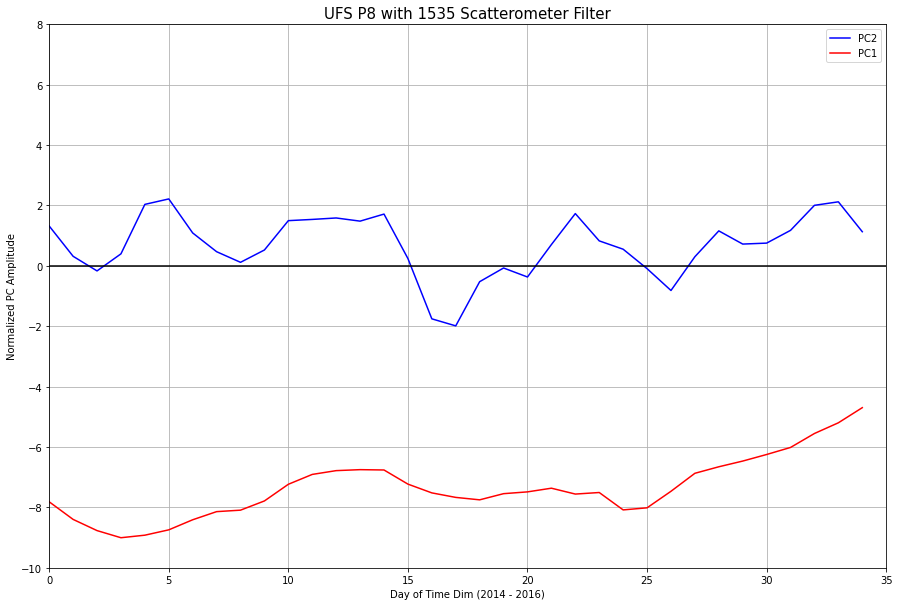

In [43]:
plt.figure(figsize = (15,10))
plt.plot(PC2, 'b')
plt.plot(PC1, 'r')
plt.legend(['PC2','PC1'], loc='best')
plt.grid()
plt.axhline(y=0,color='k')
plt.xlabel('Day of Time Dim (2014 - 2016)')
plt.ylabel('Normalized PC Amplitude')
plt.ylim(ymin=-10,ymax=8)
plt.xlim(xmin=0,xmax=35)
plt.title('UFS P8 with 1535 Scatterometer Filter', fontsize=15)

In [44]:
pcmake = PC1 + np.fabs(PC2)
pcmaki = PC1 + PC2

pcmake = xr.DataArray(pcmake,name='pcmake',coords=[wmjoks.time], dims="time")
pcmaki = xr.DataArray(pcmaki,name='pcmaki',coords=[wmjoks.time], dims="time")

In [45]:
pcmake = pcmake.drop_duplicates('time', keep='first')
pcmaki = pcmaki.drop_duplicates('time', keep='first')

In [46]:
pcmake

<xarray.DataArray 'pcmake' (time: 35)>
array([-6.49768584, -8.0828873 , -8.59888588, -8.60848263, -6.8864176 ,
       -6.52873746, -7.32169398, -7.67314054, -7.9763795 , -7.26283373,
       -5.7392956 , -5.37200552, -5.19879111, -5.2713143 , -5.04864432,
       -6.98839317, -5.7633354 , -5.67959149, -7.22338537, -7.47268475,
       -7.1148683 , -6.66090158, -5.82944737, -6.68165198, -7.53360171,
       -7.9200547 , -6.64935715, -6.56984111, -5.49853146, -5.74627069,
       -5.49701332, -4.84092236, -3.54995989, -3.07976077, -3.56907095])
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00

In [47]:
pcmaki

<xarray.DataArray 'pcmaki' (time: 35)>
array([-6.49768584, -8.0828873 , -8.93719654, -8.60848263, -6.8864176 ,
       -6.52873746, -7.32169398, -7.67314054, -7.9763795 , -7.26283373,
       -5.7392956 , -5.37200552, -5.19879111, -5.2713143 , -5.04864432,
       -6.98839317, -9.27557542, -9.65804559, -8.27560129, -7.61801154,
       -7.85696784, -6.66090158, -5.82944737, -6.68165198, -7.53360171,
       -8.10793873, -8.28397203, -6.56984111, -5.49853146, -5.74627069,
       -5.49701332, -4.84092236, -3.54995989, -3.07976077, -3.56907095])
Coordinates:
  * time     (time) object 2014-01-01 00:00:00 ... 2014-02-04 00:00:00

In [48]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

Because we are investigating the MJO influence in April, May, June (AMJ), we set our start date to the 1st april first. And then, we need to change the window of the time delta from 90 to 35 days, since our forecast is initialized every 15 days, and has a length of 35 days per initialization. Then, we need to alter the script to read forward instead of backward, by changing the operation of stdt with the relative delta from subtraction to addition. This means that we are adding 35 days ahead, instead of looking back every 90 days.

In [49]:
startYear = '2014-1-1'
endYear = '2014-2-4'
#startYear=sst['time'][0]
print('startYear=',startYear)
#endYear=sst['time'][-1] 
print('endYear=',endYear)
date_format = '%Y-%m-%d'
stdt = datetime.strptime(startYear, date_format)
edt = datetime.strptime(endYear, date_format)
#stdt = datetime.strptime(str(startYear.values)[0:10], date_format)
print('stdt=',stdt)
#edt = datetime.strptime(str(endYear.values)[0:10], date_format) 
print('edt=',edt)

startYear= 2014-1-1
endYear= 2014-2-4
stdt= 2014-01-01 00:00:00
edt= 2014-02-04 00:00:00


In [50]:
print('Calculating MaKE index')
make = list()
maki = list()

datemin = datetime(stdt.year, stdt.month, stdt.day)
datemax = datetime(edt.year, edt.month, edt.day)
    
print('datemin=',datemin)
print('datemax=',datemax)

while stdt <= edt:
    padt = stdt + relativedelta(days=35)
    make.append(pcmake.sel(time=slice(stdt.strftime(date_format),padt.strftime(date_format))).min('time',skipna='True').data.tolist())
    maki.append(pcmaki.sel(time=slice(stdt.strftime(date_format),padt.strftime(date_format))).min('time',skipna='True').data.tolist())
    stdt = stdt + relativedelta(months=1)
    #print(stdt)
    
time_mon = pd.date_range(datemin, datemax, freq='MS')#.to_pydatetime().tolist()
make = xr.DataArray(make,name='make',coords=[time_mon],dims="time")
maki = xr.DataArray(maki,name='maki',coords=[time_mon],dims="time")

make_n = make/np.std(make)
maki_n = maki/np.std(maki)

Calculating MaKE index
datemin= 2014-01-01 00:00:00
datemax= 2014-02-04 00:00:00


In [51]:
make_n

<xarray.DataArray 'make' (time: 2)>
array([-4.56979159, -2.56979159])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-02-01

In [52]:
maki_n

<xarray.DataArray 'maki' (time: 2)>
array([-4.00988105, -2.00988105])
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 2014-02-01

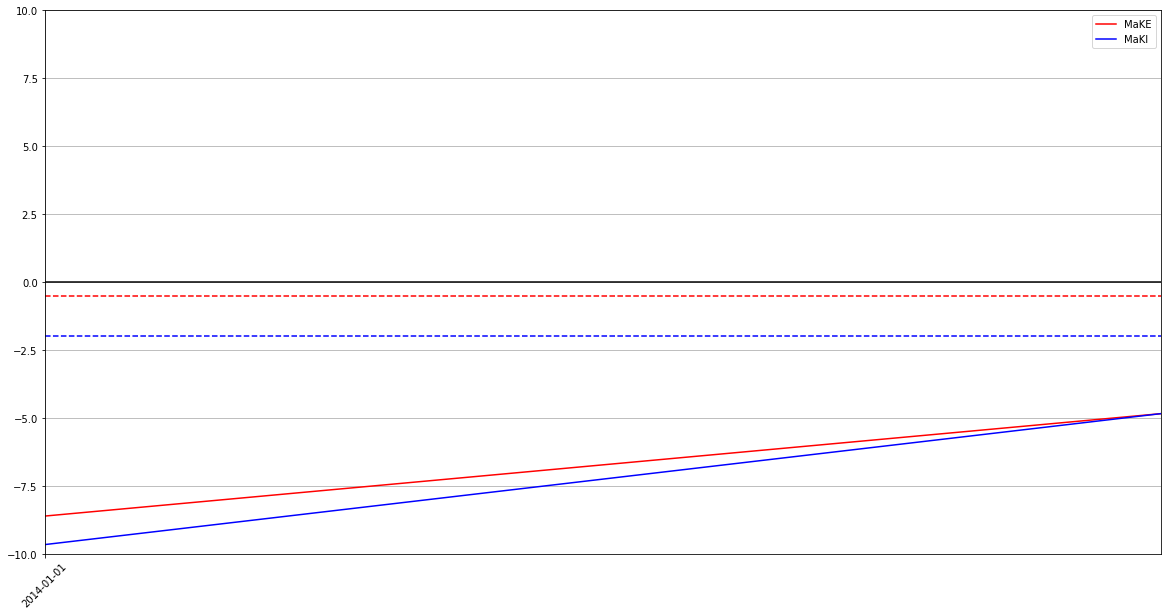

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(time_mon,make,'r')
plt.plot(time_mon,maki,'b')
plt.axhline(y=0,color='k')
plt.axhline(y=-0.5,color='r',linestyle='--')
plt.axhline(y=-2,color='b',linestyle='--')
plt.xlim([time_mon[0],time_mon[len(time_mon)-1]])
plt.xticks(time_mon[0::12], rotation=45)
plt.ylim([-10,10])
plt.grid();
plt.legend(['MaKE','MaKI'], loc='best')
#plt.savefig('MaKE-MaKI.png')
